In [1]:
import os
import urllib

import pandas as pd

from helpers.cell_type_naming import nice_to_weirds, weird_to_nice

In [2]:
experiment_name = "defaults"
experiment_uri = os.path.join(
    "gs://liulab/csx_experiments/varying_simple_parameters", experiment_name
)

experiment_uri

'gs://liulab/csx_experiments/varying_simple_parameters/defaults'

In [3]:
!gsutil --quiet rm -r $experiment_uri

In [4]:
mixture_source = "gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/mixture_melanoma_Tirosh_SuppFig_3b-d.txt"
# mixture_filename = os.path.basename(mixture_source)
mixture_filename = "mymixture.txt"
mixture_target = os.path.join(experiment_uri, "in", mixture_filename)

!gsutil cp $mixture_source $mixture_target

sc_refsample_source = "gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/scRNA-Seq_reference_melanoma_Tirosh_SuppFig_3b-d.txt"
# sc_refsample_filename = os.path.basename(sc_refsample_source)
sc_refsample_filename = "myscrefsample.txt"
sc_refsample_target = os.path.join(experiment_uri, "in", sc_refsample_filename)

!gsutil cp $sc_refsample_source $sc_refsample_target

Copying gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/mixture_melanoma_Tirosh_SuppFig_3b-d.txt [Content-Type=text/plain]...
/ [1 files][  6.0 MiB/  6.0 MiB]                                                
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/scRNA-Seq_reference_melanoma_Tirosh_SuppFig_3b-d.txt [Content-Type=text/plain]...
/ [1 files][ 87.8 MiB/ 87.8 MiB]                                                
Operation completed over 1 objects/87.8 MiB.                                     


In [5]:
experiment_path = "/mnt/buckets/liulab" + urllib.parse.urlparse(experiment_uri).path

In [6]:
!tree -h $experiment_path

/mnt/buckets/liulab/csx_experiments/varying_simple_parameters/defaults
└── [   0]  in
    ├── [6.0M]  mymixture.txt
    └── [ 88M]  myscrefsample.txt

1 directory, 2 files


In [ ]:
"""
>[Options] single_cell: TRUE
>[Options] refsample: files/william_grisaitis@dfci.harvard.edu/myrefsample.txt
>[Options] replicates: 5
>[Options] sampling: 0.5
>[Options] fraction: 0.75
>[Options] k.max: 999
>[Options] q.value: 0.01
>[Options] G.min: 300
>[Options] G.max: 500
>[Options] filter: FALSE
>[Options] verbose: TRUE
>[Options] QN: FALSE
>[Options] outdir: files/william_grisaitis@dfci.harvard.edu/results/
"""

In [7]:
command = f"""docker run \
    --rm \
    -v {experiment_path}/in:/src/data \
    -v {experiment_path}:/src/outdir \
    --user "$(id -u):$(id -g)" \
    cibersortx/fractions:latest \
    --username lyronctk@stanford.edu \
    --token dfeba2c8b9d61daebee5fa87026b8e56 \
    --single_cell TRUE \
    --refsample {sc_refsample_filename} \
    --mixture {mixture_filename} \
    --verbose TRUE
""".replace(
    "    ", " \\\n    "
)
print(command)

docker run \
     --rm \
     -v /mnt/buckets/liulab/csx_experiments/varying_simple_parameters/defaults/in:/src/data \
     -v /mnt/buckets/liulab/csx_experiments/varying_simple_parameters/defaults:/src/outdir \
     --user "$(id -u):$(id -g)" \
     cibersortx/fractions:latest \
     --username lyronctk@stanford.edu \
     --token dfeba2c8b9d61daebee5fa87026b8e56 \
     --single_cell TRUE \
     --refsample myscrefsample.txt \
     --mixture mymixture.txt \
     --verbose TRUE



In [8]:
!{command}

>Running CIBERSORTxFractions...
>[Options] username: lyronctk@stanford.edu
>[Options] token: dfeba2c8b9d61daebee5fa87026b8e56
>[Options] single_cell: TRUE
>[Options] refsample: myscrefsample.txt
>[Options] mixture: mymixture.txt
>[Options] verbose: TRUE
>Making reference sample file.
>Making phenotype class file.
>single_cell is set to TRUE, so quantile normalization is set to FALSE, and the default parameters for building the signature matrix have been set to the following values:
	- G.min <- 300
	- G.max <- 500
	- q.value <- 0.01
>==========Signature Matrix Settings============
>Pure samples file: /src/outdir//CIBERSORTx_myscrefsample_inferred_refsample.txt
>Phenotype classes file: /src/outdir//CIBERSORTx_myscrefsample_inferred_phenoclasses.txt
>Minimum number of DEGs to consider from each phenotype for signature matrix set to: 300
>Maximum number of DEGs to consider from each phenotype for signature matrix set to: 500
>Q-value for signature matrix construction set to: 0.01
>Quantile

In [9]:
!tree -h $experiment_path

/mnt/buckets/liulab/csx_experiments/varying_simple_parameters/defaults
├── [4.3K]  CIBERSORTx_Results.txt
├── [3.8M]  CIBERSORTx_cell_type_sourceGEP.txt
├── [172K]  CIBERSORTx_myscrefsample_inferred_phenoclasses.CIBERSORTx_myscrefsample_inferred_refsample.bm.K999.pdf
├── [510K]  CIBERSORTx_myscrefsample_inferred_phenoclasses.CIBERSORTx_myscrefsample_inferred_refsample.bm.K999.txt
├── [ 725]  CIBERSORTx_myscrefsample_inferred_phenoclasses.txt
├── [ 18M]  CIBERSORTx_myscrefsample_inferred_refsample.txt
└── [   0]  in
    ├── [6.0M]  mymixture.txt
    └── [ 88M]  myscrefsample.txt

1 directory, 8 files


In [10]:
fractions_csx = (
    pd.read_csv(
        os.path.join(experiment_uri, "CIBERSORTx_Results.txt"), sep="\t", index_col=0
    )
    .rename_axis(index="mixture_id")
    .rename(columns=weird_to_nice)
    .iloc[:, :-3]
)

fractions_csx.sample(5)

,Malignant,Endothelial,CAF,T CD8,NK,Macrophage,T CD4,B
mixture_id,,,,,,,,
78,0.998242,0.000000,0.000589,0.000000,0.000000,0.000000,0.000133,0.001037
84,0.066098,0.001412,0.009710,0.190298,0.075860,0.146086,0.362447,0.148089
72,0.000000,0.000000,0.000346,0.000000,0.013375,0.004722,0.730090,0.251467
79,0.535874,0.012133,0.002669,0.252050,0.000000,0.030821,0.114126,0.052326
53,0.046178,0.027261,0.058420,0.286861,0.164019,0.084984,0.332278,0.000000


In [11]:
signature_matrix = (
    pd.read_csv(
        os.path.join(
            experiment_uri,
            "CIBERSORTx_myscrefsample_inferred_phenoclasses.CIBERSORTx_myscrefsample_inferred_refsample.bm.K999.txt",
        ),
        sep="\t",
        index_col=0,
    )
    .rename_axis(index="gene")
    .rename(columns=weird_to_nice)
)

signature_matrix.sample(5)

,Malignant,Endothelial,CAF,T CD8,NK,Macrophage,T CD4,B
gene,,,,,,,,
C3orf38,18.308982,1.000000,12.625428,1.000000,115.558058,1.000000,1.000000,113.088122
CCL4L2,1.000000,1.000000,1.000000,820.855825,402.595044,65.297465,221.273159,1.000000
OLFML1,1.000000,102.926957,37.931100,1.000000,1.000000,1.000000,1.000000,1.000000
P2RY13,1.000000,1.000000,1.000000,1.000000,1.000000,31.427093,1.000000,1.000000
PDCD1,1.000000,1.000000,1.000000,395.843560,1.000000,1.000000,501.691024,1.000000


In [12]:
fractions_truth = (
    pd.read_csv(
        "gs://liulab/csx_example_files/groundtruth_Melanoma_Tirosh_et_al_SuppFig3b-d.txt",
        sep="\t",
        index_col=0,
    )
    .rename_axis(index="mixture_id")
    .rename(columns=weird_to_nice)
)

fractions_truth

,Malignant,Endothelial,CAF,T CD8,NK,Macrophage,T CD4,B
mixture_id,,,,,,,,
53,0.1280,0.0880,0.0320,0.2000,0.0800,0.0960,0.3760,0.0000
58,0.0000,0.0000,0.0000,0.6508,0.0317,0.0159,0.2857,0.0159
59,0.8710,0.0000,0.1129,0.0000,0.0000,0.0161,0.0000,0.0000
60,0.0448,0.0000,0.0000,0.1940,0.0498,0.0199,0.2139,0.4776
65,0.0755,0.0000,0.0000,0.4717,0.0000,0.0189,0.3396,0.0943
67,0.0000,0.0000,0.0000,0.3059,0.0118,0.0000,0.4588,0.2235
71,0.6835,0.0000,0.0000,0.1899,0.0000,0.0253,0.1013,0.0000
72,0.0000,0.0000,0.0000,0.1634,0.0065,0.0000,0.6013,0.2288
74,0.0000,0.0000,0.0000,0.6496,0.0073,0.0365,0.2117,0.0949


In [13]:
import plotly.io

plotly.io.renderers.default = "jupyterlab+png"

import plotly.express as px
import plotly.graph_objects as go

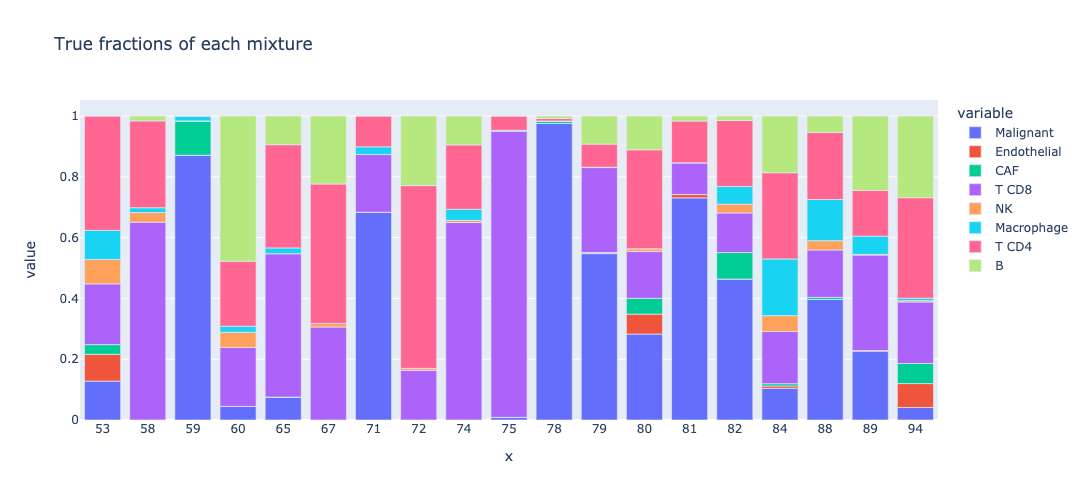

In [14]:
fig = px.bar(
    fractions_truth,  # .astype(index={"mixture_id": str}),
    x=fractions_truth.index.astype(str),
    y=fractions_truth.columns,
    title="True fractions of each mixture",
)

fig.show()

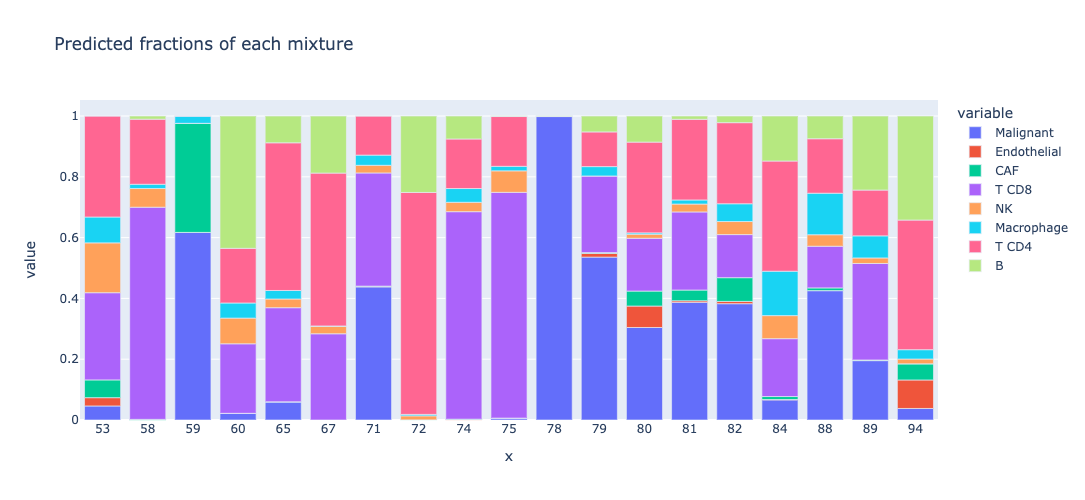

In [15]:
fig = px.bar(
    fractions_csx,  # .astype(index={"mixture_id": str}),
    x=fractions_csx.index.astype(str),
    y=fractions_csx.columns,
    title="Predicted fractions of each mixture",
)

fig.show()